# Cyber Data Analytics - 2

In [3]:
%matplotlib inline

import pandas as pd
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.api as smt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.alphabet import cuts_for_asize
from saxpy.sax import ts_to_string

from datetime import datetime
import os
import sys
from pathlib import Path

ROOT = Path(os.getcwd())

In [9]:
def parse_date(d):
    return datetime.strptime(d, '%d/%m/%y %H')

data1 = pd.read_csv('training_dataset1.csv', index_col=0, parse_dates=True, squeeze=True, date_parser=parse_date)
data2 = (data1.head(338)) # 2 weeks period instead of one year
data1.head(5)

L_T1      L_T2      L_T3      L_T4      L_T5  \
DATETIME                                                                
2014-01-06 00:00:00  0.509730  2.049003  3.191145  2.792634  2.656091   
2014-01-06 01:00:00  0.412580  2.009072  3.642565  2.831673  3.126387   
2014-01-06 02:00:00  0.320112  1.986093  4.140192  3.256733  3.574601   
2014-01-06 03:00:00  0.332879  2.009203  4.673478  3.744497  3.952379   
2014-01-06 04:00:00  0.483496  2.089049  5.237937  4.409456  3.504676   

                         L_T6      L_T7      F_PU1  S_PU1      F_PU2  \
DATETIME                                                               
2014-01-06 00:00:00  5.316831  1.562321  98.998444      1  99.018150   
2014-01-06 01:00:00  5.494855  1.852043  99.095901      1  99.115639   
2014-01-06 02:00:00  5.500000  2.246126  98.420959      1  98.440498   
2014-01-06 03:00:00  5.500000  3.203573  97.575172      1  97.594460   
2014-01-06 04:00:00  5.500000  4.439714  97.351059      1  97.370277   

                       ...        P_J256     P_J289     P_J415     P_J302  \
DATETIME               ...                                                  
2014-01-06 00:00:00    ...     87.605774  26.495605  84.206619  18.901676   
2014-01-06 01:00:00    ...     89.448341  26.487326  85.900085  18.849329   
2014-01-06 02:00:00    ...     91.056114  26.487364  86.582474  19.597170   
2014-01-06 03:00:00    ...     92.594353  26.575815  88.020546  26.028486   
2014-01-06 04:00:00    ...     94.473099  26.723457  90.422462  26.209970   

                        P_J306     P_J307     P_J317      P_J14     P_J422  \
DATETIME                                                                     
2014-01-06 00:00:00  81.983734  18.791777  67.125603  29.387470  28.487471   
2014-01-06 01:00:00  82.150589  18.739643  67.178696  29.354256  28.454256   
2014-01-06 02:00:00  83.988579  19.496712  72.425293  29.354538  28.454538   
2014-01-06 03:00:00  64.670486  25.922703  76.275040  29.449951  28.549952   
2014-01-06 04:00:00  64.746620  26.104692  76.703529  29.574265  28.674263   

                     ATT_FLAG  
DATETIME                       
2014-01-06 00:00:00         0  
2014-01-06 01:00:00         0  
2014-01-06 02:00:00         0  
2014-01-06 03:00:00         0  
2014-01-06 04:00:00         0  

[5 rows x 44 columns]

# Familiarization task – 1 A

Load the BATADAL sensor data (start with training data 1, optimize using training data 2, test 
with test data) into your favorite analysis platform (R, Matlab, Python, Weka, KNIME, ...) and 
understand the data. Answer the following questions: 

* What kinds of signals are there?

* Are the signals correlated? Do they show cyclic behavior?
To determine correlation of different signals we plotted below a heatmap. The heatmap shows: 

Very strong positive correlations between:

The status- with the flow of pump: 2,4,6,7,8,10,11
The flow of pump 1 with P_J280
The flow and status of pump 2 with P_J269  
The flow and status of pump 4 with P_J256
The flow and status of pump 7 with P_J415
The flow and status of pump 8 with P_J306
The flow and status of pump 10 with P_J317
The status- with the flow of valve: 2
Suction and discharge pressures: P_J300&P_J289&P_J422
Suction and discharge pressures: P_J302&P_J307

Very strong negative correlations between:

The status- and the flow (of the pumps PU):
The flow of pump 1 with the status and flow of pump 2
The flow of pump 1 with P_J269 
The flow and status of pump 2 with P_J280 
The flow and status of pump 8 with P_J302&P_J307
The status- and the flow of valve 2 with P_J14
Suction and discharge pressures: P_J269&P_J280
Suction and discharge pressures: P_J302&P_J306

The graphs below shows a cycle #images cycles in overleaf , content cycle per ... 

* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of p

### Data description
All data are provided in tabular format with the first column reporting the timestamp of the readings and the
remaining columns reporting the value of each different sensor. An additional column contains a binary flag
to discriminate normal conditions (flag = 0) from under attack (flag = 1). This column will contain the value
-999 for unlabeled data. The available SCADA readings are:
* Water level in each tank;
* Status (0 for OFF/CLOSED, 1 for ON/OPEN) for each pump and valve in the system;
*  Flow through each pump and valve;
*  Suction pressure and discharge pressure for each valve and pumping station.
The variables are indicated using the prefix L for water level, S for status, F for flow, and P for pressure.
The sensor labels (i.e., header of the data files) are formed by linking the variable prefix with the label of a
4
node/component in the map using the underscore symbol _. For instance, L_T1 indicates the water level in
T1, S_PU1 the status of pump PU1, while P_J280 and P_J269 are the suction and discharge pressures of
pumping station S1 (as shown in the .inp file, junction J280 and J269 are respectively located at the inlet
and outlet of pumping station S1).

The flow data unit is LPS, pressure and water level units are meters.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff58377fe10>,
      dtype=object)

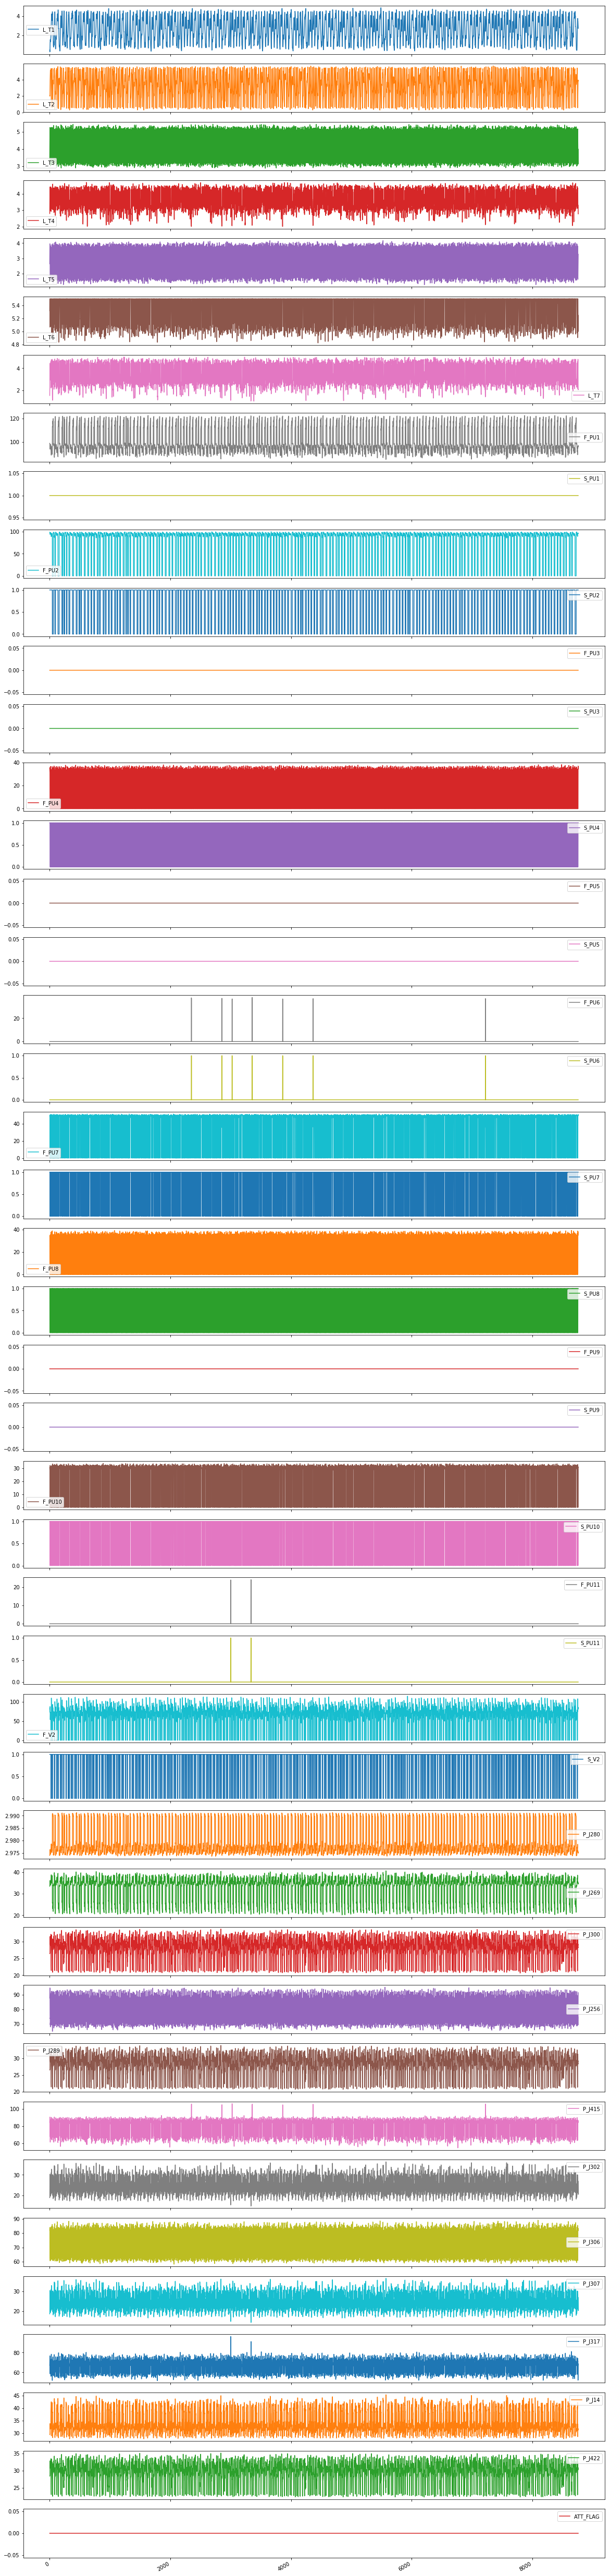

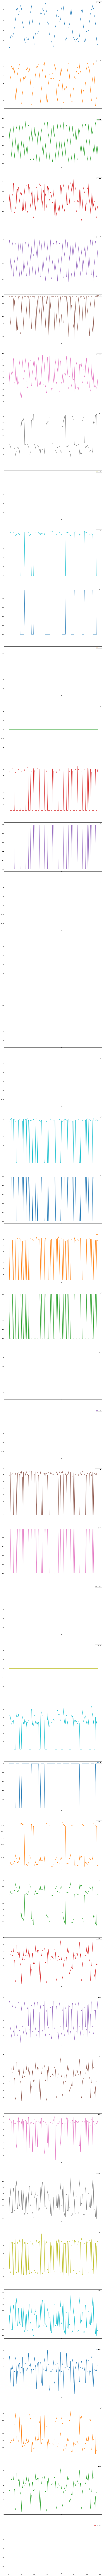

In [3]:
data1.plot(subplots=True,figsize=(20, 100))
data2.plot(subplots=True,figsize=(20, 600))

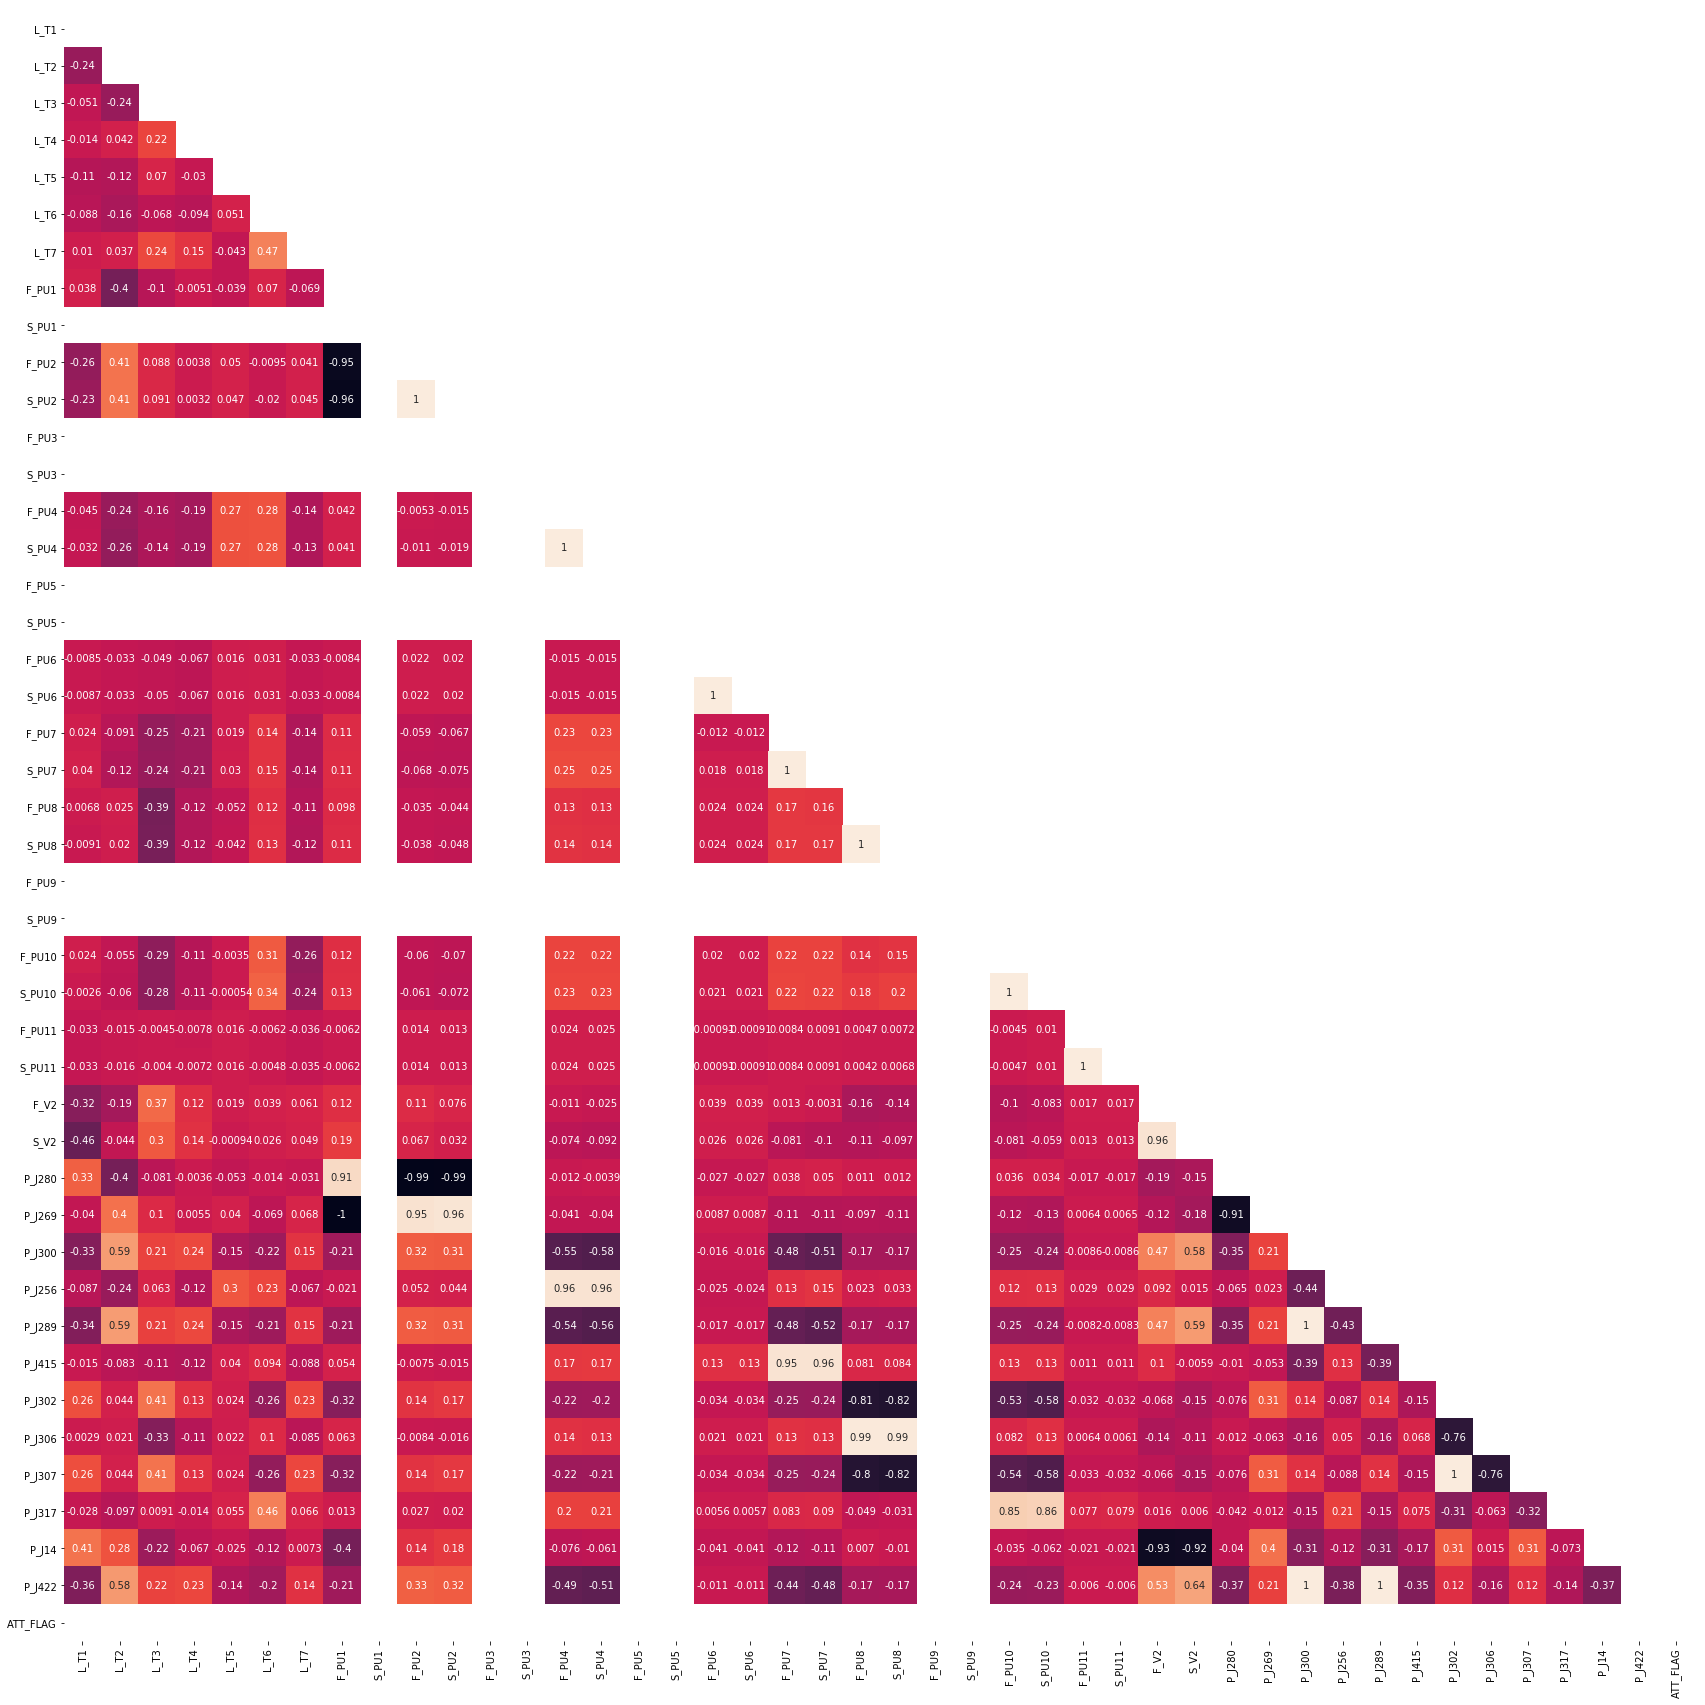

In [14]:
corr = data1.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots()
fig.set_size_inches(30, 30)

sns.heatmap(corr, annot=True, mask=mask, square=True , ax=ax, cbar=False)

### Predicting next value in series

###### Persistance
Baseline, simply taks the previous $t-1$ value and predicts the next with it.

###### Linear regression
Create a model from 4 values and predict the subsequent 5th value.

In [4]:
def persistance(values):
    df = pd.concat([values.shift(1), values], axis=1)
    df.columns = ['t-1', 't+1']

    X = df.values
    train_size = int(len(X) * 0.8)
    train, test = X[1:train_size], X[train_size:]
    train_X, train_y = train[:,0], train[:,1]
    test_X, test_y = test[:,0], test[:,1]

    predictions = [x for x in test_X]
    test_score = mean_squared_error(test_y, predictions)
    
    return test_score

def regression(values, classifier='linreg'):
    def lin_reg(y):
        
        x = np.array(list(range(0, 4))).reshape(-1, 1)
        y = y[:-1]
        if classifier == 'linreg':
            clf = LinearRegression()
        elif classifier == 'regtree':
            clf = DecisionTreeRegressor()
        clf.fit(x, y)
        y_predicted = clf.predict(5)
        return mean_squared_error(x[-1], y_predicted)
    
    return values.rolling(5).apply(lin_reg).dropna().mean()[0]

print('COLUMN   MSE PERSISTANCE   MSE LINREG   MSE REGTREE')
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG']:
        values = pd.DataFrame(data1[column].values)
        mse_persistance = persistance(values)
        mse_lin_reg = regression(values, classifier='linreg')
        mse_reg_tree = regression(values, classifier='regtree')
        print('{}     {:.3f}           {:.3f}        {:.3f}'.format(column, mse_persistance, mse_lin_reg, mse_reg_tree))

COLUMN   MSE PERSISTANCE   MSE LINREG   MSE REGTREE
L_T1     0.055           2.075        1.550
L_T2     0.213           4.140        2.239
L_T3     0.143           3.064        1.905
L_T4     0.203           1.277        0.614
L_T5     0.242           2.309        0.604
L_T6     0.026           5.749        5.650


KeyboardInterrupt: 

## ARMA task – 1/2 A4 
Learn an autoregressive moving average model (see Wikipedia for an introduction if unfamiliar) 
for each individual sensor. Most statistical packages (R, statsmodels in Python) contain standard 
algorithm for fitting these models from training data. Use autocorrelation plots in order to 
identify the order of the ARMA models. The parameters can be determined using Akaike’s 
Information Criterion (AIC) or another model selection method. Note that there exists a wide 
range of ARMA variants; you only have to use the basic model.

Decide how to set the detection threshold sensibly. Study some of the anomalies detected 
anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be 
modeled effectively using ARMA?

#### Autocorrelation

High correlation: close to the regression line

Autocorrelation: How well does a $current-x$ value relate to the $current$ value. Plot with $current$ on one axis and incrementing $x$ on other axis.

Partial correlation: Is the error after fitting the regression line to the autocorrelation.

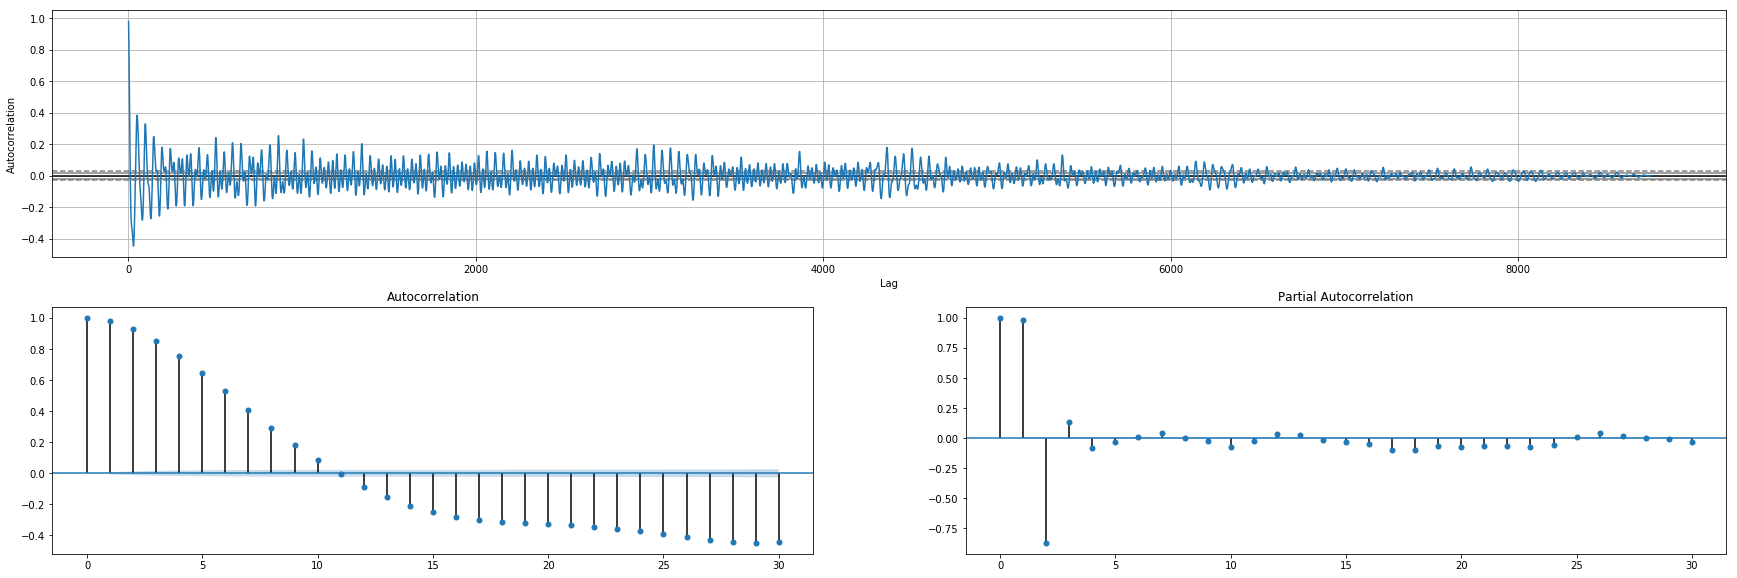

In [ ]:
for column in data1:
    if column not in ['DATETIME', 'ATT_FLAG', 'F_PU3','F_PU3', 'F_PU5', 'F_PU6', 'F_PU9', 'F_PU11', 'S_PU1','S_PU3','S_PU5', 'S_PU6','S_PU9', 'S_PU11']:
        fig = plt.figure(figsize=(30, 10))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        autocorrelation_plot(data1[column], ax=ts_ax)
        smt.graphics.plot_acf(data1[column], lags=30, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(data1[column], lags=30, ax=pacf_ax, alpha=0.5)
        break

#### ARMA

To estimate the ARMA order values we did a grid search on each sensors data, the best model is chosen based on the lowest value for Akaike’s Information Criterion (AIC).

In [ ]:
column = 'F_PU10'

r = 6
lowest_aic = np.inf
best_pq = (-1, -1)

for p in range(r):
    for q in range(r):
        try:
            order = (p, q)
            model = ARMA(data1[column], order=order).fit(method='mle')
            print('({}, {}): {}'.format(p, q, model.aic))
            
            if model.aic < lowest_aic:
                lowest_aic = model.aic
                best_pq = order
                
        except Exception as e:
            print('({}, {}): {}'.format(p, q, str(e)))

print('Best fit: {}, {}'.format(lowest_aic, best_pq))
# residuals = pd.DataFrame(model_fit.resid)
# print(residuals.describe())
# residuals.plot()
# residuals.plot(kind='kde')

(0, 0): 68524.00877353296
(0, 1): 67223.32820698248


C:\Users\Sophi\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\Sophi\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


(0, 2): 67199.4658660979
(0, 3): 66964.6954751982
(0, 4): 66904.27940507479
(0, 5): 66892.2108573164
(1, 0): 67668.45221460063
(1, 1): 67212.37550586228
(1, 2): 66735.50222369027
(1, 3): 66685.20688027825
(1, 4): 66663.39225948905
(1, 5): 66664.53005913614
(2, 0): 66981.92903885113
(2, 1): 66955.97818325767
(2, 2): 66700.73346176167


### Example predict

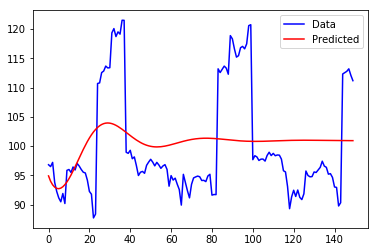

In [105]:
column = 'F_PU10'

train = data1[column][:5000]
test = data1[column][5000:5150]

model = ARMA(train, order=best_pq).fit(method='mle')

x = (5000, 5150)
predict = model.predict(*x)

y = []
y_hat = []
for y_predicted, y_test in zip(predict, test):
    y.append(y_test)
    y_hat.append(y_predicted)
    
fig, ax = plt.subplots()
ax.plot(y, color='b', label='Data')
ax.plot(y_hat, color='r', label='Predicted')
# ax.title('Fit {}'.format(str(best_pq)))
ax.legend(loc='best')

# Get error between curves?

## Discrete models task - 1/2 A4
Discretize the sensor data using any of the methods discussed in class. Explain why you choose 
this method and why the obtained discretization makes sense. Visualize the discretization.
Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, ...) to 
sliding windows with a length of your choosing in order to find anomalies. Whenever an 
observed N-gram’s probability is too small, or the sequential data is too distant from any training 
sequence, raise an alarm. Set your thresholds sensibly. 

What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

-0.43072729929545756
0.33333333333333326
[      -inf -0.4307273  0.4307273]
0     0.509730
1     0.412580
2     0.320112
3     0.332879
4     0.483496
5     0.791114
6     1.186589
7     1.420449
8     1.534827
9     1.576541
10    1.558550
11    1.480654
12    1.464823
13    1.483956
14    1.383691
15    1.351578
16    1.454622
17    1.531665
18    1.662596
19    1.839003
Name: L_T1, dtype: float64
0    -1.384284
1    -1.582273
2    -1.770723
3    -1.744704
4    -1.437749
5    -0.810829
6    -0.004858
7     0.471744
8     0.704846
9     0.789857
10    0.753191
11    0.594441
12    0.562178
13    0.601171
14    0.396832
15    0.331386
16    0.541389
17    0.698400
18    0.965236
19    1.324750
Name: L_T1, dtype: float64
aaaaaabcccccccbbcccc


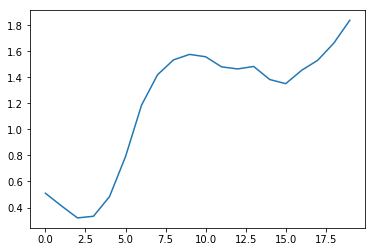

In [83]:
from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string

from scipy.stats import norm

ppf = norm.ppf(1/3)
cdf = norm.cdf(-0.43072729929545756)

column = 'L_T1'
size = 20
partial = data1[column][:size]

d_znorm = znorm(partial)
d_paa = paa(d_znorm, 3)
print(d_paa)

# print(d_paa)
print(ts_to_string(da_znorm, cuts_for_asize(3)))

plt.plot(data1[column][:size])

# 1. Choose discretization algorithm, percentiles, SAX, Change point detection and segmentation
# 2. Visualize discretization
# 3. Apply sequential data mining methods (N-grams, Sequence alignment with kNN, ...) to 
#    sliding windows with a length of your choosing in order to find anomalies
# 4. Rais alarm whenever an observed N-gram’s probability is too small, or the sequential data is 
#    too distant from any training sequence, raise an alarm. Set your thresholds sensibly. 


## PCA task – 1/2 A4 
Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a 
value that results in few false positives on the training data. Plot the PCA residuals in one signal. 
Do you see large abnormalities in the training data? Can you explain why these occur? It is best to
remove such abnormalities from the training data since you only want to model normal behavior. 
What kind of anomalies can you detect using PCA?

In [ ]:
scaler = StandardScaler()
normalized_training = scaler.fit_transform(data)
pca = decomposition.PCA(n_components=20)
pca.fit(normalized_training)
pca_model = pca.transform(normalized_training)

## Bonus task – 1 A4 
Think of a way (study the papers) to combine the predictions of all the individual models into a 
single anomaly detection method. Implement it and evaluate its effectiveness compared to each 
of the methods individually.

In [65]:
dat = np.array([0., 0., 0., 0., 0., -0.270340178359072, -0.367828308500142,
                0.666980581124872, 1.87088147328446, 2.14548907684624,
                -0.480859313143032, -0.72911654245842, -0.490308602315934,
                -0.66152028906509, -0.221049033806403, 0.367003418871239,
                0.631073992586373, 0.0487728723414486, 0.762655178750436,
                0.78574757843331, 0.338239686422963, 0.784206454089066,
                -2.14265084073625, 2.11325193044223, 0.186018356196443,
                0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.519132472499234,
                -2.604783141655, -0.244519550114012, -1.6570790528784,
                3.34184602886343, 2.10361226260999, 1.9796808733979,
                -0.822247322003058, 1.06850578033292, -0.678811824405992,
                0.804225748913681, 0.57363964388698, 0.437113583759113,
                0.437208643628268, 0.989892093383503, 1.76545983424176,
                0.119483882364649, -0.222311941138971, -0.74669456611669,
                -0.0663660879732063, 0., 0., 0., 0., 0.,])

from saxpy.znorm import znorm
from saxpy.paa import paa
from saxpy.sax import ts_to_string
p = paa([-2, 0, 2, 0, -1], 3)
print(ts_to_string(p, cuts_for_asize(3)))


aca
